In [1]:
import edward as ed
from edward.models import Poisson,Gamma
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import helper_func
import math
import models
import scipy.special as sp
from scipy.misc import logsumexp
import gc

In [2]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

In [3]:
dataset = 'movielens'  #bibx,biby,movielens
full_X,x,test_mask = helper_func.load_data(dataset)
x = full_X
result_folder = "dual_bibtex"
metric = 'mae_nz_all'
users = x.shape[0]
items = x.shape[1]
train_non_zero_indices = helper_func.non_zero_entries(x)
score = []

In [4]:
epochs = 100
epochs += 1
test_every = 10
no_samples_mle = 5000
no_sample_inf = 50
k = 50
param = models.poisson_response(users,items,20);

In [5]:
eta = 0.3 #looks like n
rho =  0.3  #looks like p
zeta = 0.3 #looks like mirror inverted c
omega = 0.3 #looks like w
cutoff_loglik = np.log(1e-6);
varrho = 1.
varpi = 1.
n_trunc = 20;

In [6]:
ar =  np.ones(shape=(users,1))*(rho+k*eta)   # not fixed in the original code
br = np.ones(shape=(users,1))   
aw = np.ones(shape=(items,1))*(omega+k*zeta)  # not fixed in the original code
bw = np.ones(shape=(items,1))
a_s = np.random.uniform(low=0.1,size=[users,k])
bs = np.random.uniform(low=0.1,size=[users,k])
av = np.random.uniform(low=0.1,size=[items,k])
bv = np.random.uniform(low=0.1,size=[items,k])
A = np.empty(shape=[users,items])

In [7]:
param.mle_update(train_non_zero_indices,x,no_samples_mle)
del train_non_zero_indices

In [8]:
curr_iter  = 0
while curr_iter <= epochs:
    print curr_iter    
    br = rho/varrho + (a_s/bs).sum(axis=1,keepdims=True)
    bs = (ar/br).repeat(k,axis=1) + ((av/bv).sum(axis=0,keepdims=True)).repeat(users,axis=0)
    bw = omega/varpi + (av/bv).sum(axis=1,keepdims=True)
    bv = (aw/bw).repeat(k,axis=1) +((a_s/bs).sum(axis=0,keepdims=True)).repeat(items,axis=0)

    A = np.matmul((a_s/bs),(av/bv).transpose())
    en = param.expectation_mat(x,A,n_trunc)
    varphi_u = (sp.digamma(a_s)-np.log(bs)).reshape((1,users,k)).repeat(items,axis=0).swapaxes(0,1)
    varphi_i = (sp.digamma(av)-np.log(bv)).reshape((1,items,k)).repeat(users,axis=0)
    varphi = varphi_u + varphi_i
    log_norm = logsumexp(varphi,axis=2)
    varphi = np.exp(varphi-log_norm[:,:,np.newaxis])
    temp = en[:,:,np.newaxis]*varphi
    a_s = eta + temp.sum(axis=1)
    av = zeta + temp.sum(axis=0)
    
    assert np.isfinite(br).all()
    assert np.isfinite(bs).all()
    assert np.isfinite(bw).all()
    assert np.isfinite(bv).all()
    assert np.isfinite(A).all()
    assert np.isfinite(en).all()
    assert np.isfinite(varphi).all()
    assert np.isfinite(a_s).all()
    assert np.isfinite(av).all()
    gc.collect()
    
    
    if curr_iter%test_every == 0:
#         q_theta = Gamma(a_s,bs)
#         q_beta = Gamma(np.transpose(av),np.transpose(bv))
#         beta_sample = q_beta.sample(no_sample_inf).eval()
#         theta_sample = q_theta.sample(no_sample_inf).eval()    
#         score.append(helper_func.check(param,theta_sample,beta_sample,test_mask,full_X,metric=metric))
        score.append(helper_func.mae_nz_all(x,param.lam*en))        print score[-1]

        print score[-1]
        gc.collect()
        
#         score.append(helper_func.check(param,theta_sample,beta_sample,test_mask,full_X,metric=metric))
#         ind = x.nonzero()
#         print np.sum(np.absolute(x[ind]-param.lam*en[ind]))/ind[0].size
        gc.collect()
    curr_iter += 1


0
3.52833651591
1
2
3
4
5
6
7
8
9
10
3.52637985137
11
12
13
14
15
16
17
18
19
20
3.52464420769
21
22
23
24
25
26
27
28
29
30
3.52288282226
31
32
33
34
35
36
37
38
39
40
3.52109038383
41
42
43
44
45
46
47
48
49
50
3.51926619976
51
52
53
54
55
56
57
58
59
60
3.51740918228
61
62
63
64
65
66
67
68
69
70
3.51551817355
71
72
73
74
75
76
77
78
79
80
3.51359195591
81
82
83
84
85
86
87
88
89
90
3.51162924874
91
92
93
94
95
96
97
98
99
100
3.50962870449
101


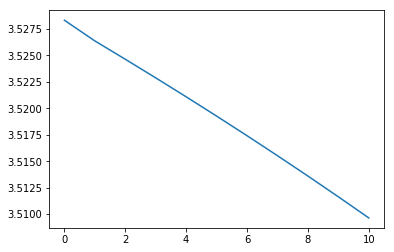

3.50962870449


In [9]:
plt.plot(score)
plt.show()
print min(score)